# Baseline Model

This notebook is to showthe results for the baseline model.  This is the standard autoencoder architecture before adding any of the training methods to be analysed.

## Imports

In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

## Data

In [2]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  %cp "/content/drive/My Drive/autoencoder-training/data.zip" .
  !unzip -q data.zip
  image_path = "data"
else: 
  os.chdir("../")
  image_path = os.getcwd() + "/data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

size = 32
batchsize = 128

#tfms = get_transforms(do_flip = True)
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0, 
                      p_lighting=0.75)
src = (ImageImageList.from_folder(image_path).split_by_folder().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

## Model

In [0]:
class reshape(nn.Module):
  def __init__(self, shape):
      super(reshape, self).__init__()
      self.shape = shape
  def forward(self, x): return x.reshape(self.shape)

In [0]:
class convblock(nn.Module):
  def __init__(self, in_:int, out:int):
    super().__init__()
    self.conv1 = nn.Conv2d(in_, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn = nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    return x

class downsamp(nn.Module):
  def __init__(self, size:int, scale:int=2):
    super().__init__()
    self.pool = nn.AdaptiveMaxPool2d(scale)
    self.bn = nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu = nn.ReLU(inplace = True)

  def forward(self,x):
    x = self.pool(x)
    x = self.bn(x)
    x = self.relu(x)
    return x

In [0]:
class encoder1(nn.Module):
  def __init__(self):
    super(encoder1, self).__init__()
    self.convblock1 = convblock(3, 12)
    self.convblock2 = convblock(12,12)
    self.downsamp1 = downsamp(12, 16)

    self.convblock3 = convblock(12, 12)
    self.convblock4 = convblock(12,24)
    self.downsamp2 = downsamp(24, 8)

    self.bottleneck = nn.Sequential(nn.Flatten(),
                                    nn.Linear(24 * 8 * 8, 1000)
                                    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.downsamp1(x)

    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.downsamp2(x)

    x = self.bottleneck(x)

    return x


class encoder2(nn.Module):
  def __init__(self):
    super(encoder2, self).__init__()
    self.convblock1 = convblock(3, 12)
    self.downsamp1 = downsamp(12, 16)

    self.convblock2 = convblock(12,24)
    self.downsamp2 = downsamp(24, 8)

    self.bottleneck = nn.Sequential(nn.Flatten(),
                                    nn.Linear(24 * 8 * 8, 1000)
                                    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.downsamp1(x)

    x = self.convblock2(x)
    x = self.downsamp2(x)

    x = self.bottleneck(x)

    return x

In [0]:
class Upsample1(nn.Module):
  def __init__(self, in_:int, out:int, scale:int=2, blur:bool=True):
    super().__init__()
    self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
    self.bn = nn.BatchNorm2d(in_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
    )
    self.conv2 = nn.Sequential(
            nn.Conv2d(out, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
    )

  def forward(self, x):
    x = self.upsample(x)
    x = self.bn(x)
    x = self.conv1(x)
    x = self.conv2(x)
    return x


class Upsample2(nn.Module):
  def __init__(self, in_:int, out:int, scale:int=2, blur:bool=True):
    super().__init__()
    self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
    self.bn = nn.BatchNorm2d(in_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
    )

  def forward(self, x):
    x = self.upsample(x)
    x = self.bn(x)
    x = self.conv1(x)
    return x

In [0]:
class decoder1(nn.Module):
  def __init__(self):
    super(decoder1, self).__init__()

    self.bottleneck = nn.Sequential(nn.Linear(1000, 24 * 8 * 8),
                                    reshape([-1,24,8,8]))
    self.up1 = Upsample1(24, 12)
    self.up2 = Upsample1(12,3)

  def forward(self, x):
    x = self.bottleneck(x)
    x = self.up1(x)
    x = self.up2(x)
    return x


class decoder2(nn.Module):
  def __init__(self):
    super(decoder2, self).__init__()

    self.bottleneck = nn.Sequential(nn.Linear(1000, 24 * 8 * 8),
                                    reshape([-1,24,8,8])
    )
    self.up1 = Upsample2(24, 12)
    self.up2 = Upsample2(12,3)

  def forward(self, x):
    x = self.bottleneck(x)
    x = self.up1(x)
    x = self.up2(x)
    return x

In [0]:
class autoencoder1(nn.Module):
  def __init__(self):
    super(autoencoder1, self).__init__()

    self.encoder = encoder1()
    self.decoder = decoder1()

  def encode(self, x): return self.encoder(x)
  def decode(self, x): return torch.clamp(self.decoder(x), min = 0, max = 1)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return torch.clamp(x, min = 0, max = 1)

class autoencoder2(nn.Module):
  def __init__(self):
    super(autoencoder2, self).__init__()

    self.encoder = encoder2()
    self.decoder = decoder2()

  def encode(self, x): return self.encoder(x)
  def decode(self, x): return torch.clamp(self.decoder(x), min = 0, max = 1)
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return torch.clamp(x, min = 0, max = 1)

In [0]:
ae1 = autoencoder1()
ae2 = autoencoder2()

In [0]:
learn1 = Learner(data, ae1, loss_func = F.mse_loss)
learn2 = Learner(data, ae2, loss_func = F.mse_loss)

In [17]:
learn1.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.019191,0.020103,01:55
1,0.011296,0.012014,01:55
2,0.009362,0.011079,01:56
3,0.008631,0.009872,01:55
4,0.008358,0.009606,01:52


In [18]:
learn2.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.014998,0.012824,01:50
1,0.006388,0.007653,01:51
2,0.004993,0.006254,01:51
3,0.004122,0.005399,01:51
4,0.003797,0.005155,01:51


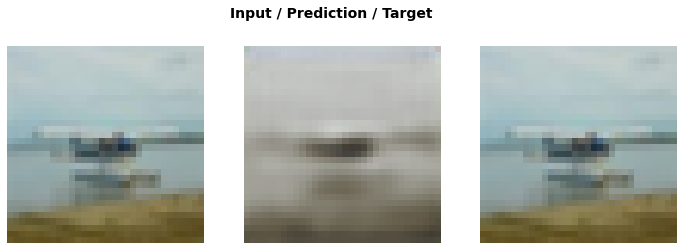

In [19]:
learn1.show_results(rows = 1)

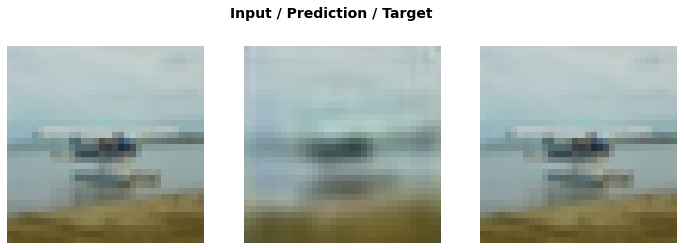

In [20]:
learn2.show_results(rows = 1)